# **Assignment #1 Face Recognition**

1) Yousef Mohamed Hassan Elmedany      20012293

2) Ahmed Khalil Elzainy                20010096

3) Karem Tarek Ibrahim                 20011112

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
source_path = "/content/drive/MyDrive/FaceRecognition Datasets/samples.zip"
destination_path = "/content"
import zipfile

with zipfile.ZipFile(source_path, 'r') as zip_ref:
  zip_ref.extractall(destination_path)


In [ ]:
source_path = "/content/drive/MyDrive/FaceRecognition Datasets/nonFaces Samples.zip"
destination_path = "/content"
import zipfile

with zipfile.ZipFile(source_path, 'r') as zip_ref:
  zip_ref.extractall(destination_path)


importing needed libraries

In [ ]:
import numpy as np
import torch
import os
import cv2
import numpy as np
import scipy as sp
import re
import time
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA as skPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Part one
1)Generate the Data Matrix and the Label vector

2)Split the Dataset into Training and Test sets



---

we implemnted two function to handle data :

1) **create_datamatrix()** : this function convert images into vector data and create vector lable

2) **split_datamatrix_and_create_alldata_50_50()** : this function split the matrix data into 50% training and 50% test data

2) **split_datamatrix_and_create_alldata_70_30()** : this function split the matrix data into 50% training and 50% test data


In [ ]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]


def create_datamatrix(root_directory="samples"):
    data_matrix = []
    labels_vector = []

    for Dir_path, dir_names, filenames in os.walk(root_directory):
        dir_names.sort(key=natural_sort_key)
        filenames.sort(key=natural_sort_key)
        for filename in filenames:
            path = os.path.join(Dir_path, filename)
            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            image_array = np.array(image)
            vector_image = image_array.flatten()

            data_matrix.append(vector_image)
            labels_vector.append((os.path.basename(Dir_path)[1:]))

    return data_matrix, labels_vector


def split_datamatrix_50_50(data_matrix, labels_vector):
    # Convert lists to NumPy arrays
    data_matrix = np.array(data_matrix)
    labels_vector = np.array(labels_vector)
    training_vector = data_matrix[1::2]
    test_vector = data_matrix[::2]
    training_label = labels_vector[1::2]
    test_label = labels_vector[::2]
    return training_vector, test_vector, training_label, test_label


def split_datamatrix_70_30(data_matrix, labels_vector):
    training_vector = []
    test_vector = []
    training_label = []
    test_label = []

    # Convert lists to NumPy arrays
    data_matrix = np.array(data_matrix)
    labels_vector = np.array(labels_vector)

    j = 1
    for i in range(len(labels_vector)):
        if j <= 7:
            training_vector.append(data_matrix[i])
            training_label.append(labels_vector[i])
        else:
            test_vector.append(data_matrix[i])
            test_label.append(labels_vector[i])

        if j == 10:
            j = 1
        j += 1

    return np.array(training_vector), np.array(test_vector), np.array(training_label), np.array(test_label)


Splitting Non faces matrix and creating non faces datamatrix and join the faces and non faces datamatrix

In [ ]:
def split_non_faces(data_matrix, labels_vector, split_test_index=200):
    training_non_faces_vector = data_matrix[split_test_index:]
    test_non_faces_vector = data_matrix[: split_test_index]
    training_non_faces_labels = labels_vector[split_test_index:]
    test_non_faces_labels = labels_vector[:split_test_index]
    return training_non_faces_vector, test_non_faces_vector, training_non_faces_labels, test_non_faces_labels


def create_non_faces_datamatrix(num_images, root_directory="nonFaces Samples"):
    data_matrix = []
    labels_vector = []

    for i in range(1, num_images + 1):
        filename = f"{i}.jpg"  # Assuming images are in JPEG format, adjust if needed
        path = os.path.join(root_directory, filename)

        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        resized_image = cv2.resize(image, (92, 112))
        if resized_image is not None:
            image_array = np.array(resized_image)
            vector_image = image_array.flatten()

            data_matrix.append(vector_image)
            labels_vector.append(2)  # Assuming non-faces have label 0

    return data_matrix, labels_vector


def create_faces_non_faces_datamatrix(num_images, split_50=True, fixing_test_no=True):
    faces_data_matrix, faces_labels_vector = create_datamatrix()
    faces_labels_vector = np.ones(len(faces_labels_vector))
    non_faces_data_matrix, non_faces_labels_vector = create_non_faces_datamatrix(num_images)
    if fixing_test_no:
        return join_faces_and_non_faces_fixing_test(faces_data_matrix, faces_labels_vector, non_faces_data_matrix,
                                                     non_faces_labels_vector, split_50)
    else:
        return join_faces_non_faces(faces_data_matrix, faces_labels_vector, non_faces_data_matrix,
                                    non_faces_labels_vector, split_50)


def join_faces_and_non_faces_fixing_test(faces_data_matrix, faces_labels_vector, non_faces_data_matrix,
                                          non_faces_labels_vector,
                                          split_50=True):
    if split_50:
        training_faces_vector, test_faces_vector, training_faces_label, test_faces_label \
            = split_datamatrix_50_50(faces_data_matrix, faces_labels_vector)
    else:
        training_faces_vector, test_faces_vector, training_faces_label, test_faces_label \
            = split_datamatrix_70_30(faces_data_matrix, faces_labels_vector)

    training_non_faces_vector, test_non_faces_vector, training_non_faces_label, test_non_faces_label \
        = split_non_faces(non_faces_data_matrix, non_faces_labels_vector)

    training_data_matrix = np.concatenate((training_faces_vector, training_non_faces_vector))
    training_labels_vector = np.concatenate((training_faces_label, training_non_faces_label))

    test_data_matrix = np.concatenate((test_faces_vector, test_non_faces_vector))
    test_labels_vector = np.concatenate((test_faces_label, test_non_faces_label))

    return training_data_matrix, test_data_matrix, training_labels_vector, test_labels_vector

def join_faces_non_faces(faces_data_matrix, faces_labels_vector, non_faces_data_matrix, non_faces_labels_vector, split_50):
    if split_50:
      training_faces_vector, test_faces_vector, training_faces_label, test_faces_label \
          = split_datamatrix_50_50(faces_data_matrix, faces_labels_vector)

      training_non_faces_vector, test_non_faces_vector, training_non_faces_label, test_non_faces_label \
          = split_datamatrix_50_50(non_faces_data_matrix, non_faces_labels_vector)
    else:

      training_faces_vector, test_faces_vector, training_faces_label, test_faces_label \
          = split_datamatrix_70_30(faces_data_matrix, faces_labels_vector)

      training_non_faces_vector, test_non_faces_vector, training_non_faces_label, test_non_faces_label \
          = split_datamatrix_70_30(non_faces_data_matrix, non_faces_labels_vector)

    training_data_matrix = np.concatenate((training_faces_vector, training_non_faces_vector))
    training_labels_vector = np.concatenate((training_faces_label, training_non_faces_label))

    test_data_matrix = np.concatenate((test_faces_vector, test_non_faces_vector))
    test_labels_vector = np.concatenate((test_faces_label, test_non_faces_label))

    return training_data_matrix, test_data_matrix, training_labels_vector, test_labels_vector


# **PCA part**

This function choose the first k eigenvalues and eigenvectors which satistifies the following formula
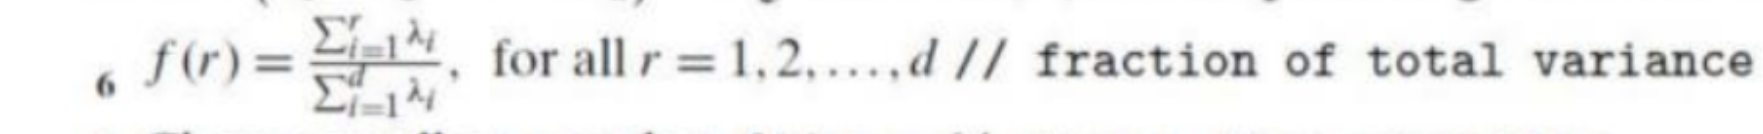

In [ ]:
def choose_dimensionality(eign_values_vector, eigen_matrix, alpha):
    choosen_eigns_values = []
    choosen_eigns_vectors = []
    eignsum = 0
    total_sum_eigns = np.sum(eign_values_vector)
    for i in range(len(eign_values_vector) - 1, -1, -1):
        eignsum += eign_values_vector[i]
        choosen_eigns_values.append(eign_values_vector[i])
        choosen_eigns_vectors.append(eigen_matrix[:, i])
        if (eignsum / total_sum_eigns) >= alpha:
            return choosen_eigns_values, choosen_eigns_vectors
    return choosen_eigns_values, choosen_eigns_vectors

This function Projects the Test Data on the projection Matrix produced from the applying pca on Training data

In [ ]:
def project_data(center_datamatrix, choosen_basis):
    choosen_basis = np.array(choosen_basis)
    projection_matrix = choosen_basis
    new_data_matrix = center_datamatrix @ projection_matrix
    return new_data_matrix, projection_matrix

Implenting PCA psuedo code with applying a trick to reduce size of covariance matrix and then multiplying it by the centered dataset to get the eigen vectors of the original covariance matrix

In [ ]:
def PCA(dataset, alpha):
    means = np.mean(dataset, axis=0)
    centered_data_set = dataset - means
    cov = centered_data_set @ centered_data_set.T
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    eigenvectors = centered_data_set.T @ eigenvectors
    for i in range(len(eigenvectors[0])):
        eigenvectors[:, i] = eigenvectors[:, i] / np.linalg.norm(eigenvectors[:, i])
    choosen_eigns_values, choosen_eigns_vectors = choose_dimensionality(eigenvalues, eigenvectors, alpha)
    choosen_eigns_vectors = np.transpose(choosen_eigns_vectors)
    new_data_set, projection_matrix = project_data(centered_data_set, choosen_eigns_vectors)
    return new_data_set, projection_matrix, means

Centering Test data and Projecting it using projection matrix from applying pca on training data

In [ ]:
def project_data_with_old_projection_matrix(dataset, projection_matrix, means):
    center_datamatrix = dataset - means
    new_data_matrix = center_datamatrix @ projection_matrix
    return new_data_matrix

Using Knn as a simple classifier where no of neighbours = 1 and try it on different alphas and then plot the accuarcy against the alphas, we chose distance as a tie breaker

In [ ]:
def pca_knn(splitting_method, no_of_neighbors=[1]):
    alpha_values = [0.8, 0.85, 0.9, 0.95]

    for n in no_of_neighbors:
        x = []
        y = []
        print(f"Number of neighbors: {n}")
        for alpha in alpha_values:
            knn = KNeighborsClassifier(n_neighbors=n, weights='distance')
            data_matrix, labels_vector = create_datamatrix()
            training_vector, test_vector, training_label, test_label = splitting_method(data_matrix, labels_vector)
            new_projected_training_data, projection_matrix, means = PCA(training_vector, alpha)

            new_projected_test_data = project_data_with_old_projection_matrix(test_vector, projection_matrix, means)
            knn.fit(new_projected_training_data, training_label)
            y_pred = knn.predict(new_projected_test_data)
            accuracy = accuracy_score(y_pred, test_label)
            x.append(alpha)
            y.append(accuracy)
            print(f"Accuracy: {accuracy:.5f}, Alpha: {alpha}")

        # Plotting
        plt.plot(x, y, marker='o')
        plt.xlabel('Alpha')
        plt.ylabel('Accuracy')
        plt.title(f"Accuracy vs. Alpha: {n} nearest neighbors")
        plt.show()

Number of neighbors: 1
Accuracy: 0.93500, Alpha: 0.8
Accuracy: 0.94500, Alpha: 0.85
Accuracy: 0.94500, Alpha: 0.9
Accuracy: 0.93500, Alpha: 0.95


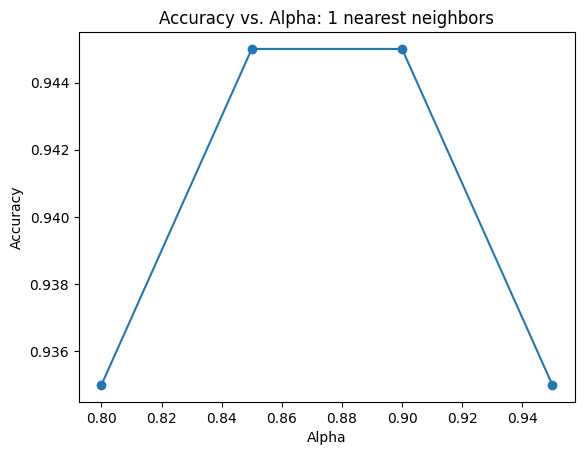

In [ ]:
pca_knn(split_datamatrix_50_50, [1])


As alpha increases accuracy increases until a certain point where accuarcy starts to decrease again that can be because by increasing alpha the number of principal components increases which can capture noise which don't generalize well and leads to the model performing poorly in face of new data

# **Classifer Tuning part adding different No of neighbours**

Number of neighbors: 1
Accuracy: 0.93500, Alpha: 0.8
Accuracy: 0.94500, Alpha: 0.85
Accuracy: 0.94500, Alpha: 0.9
Accuracy: 0.93500, Alpha: 0.95


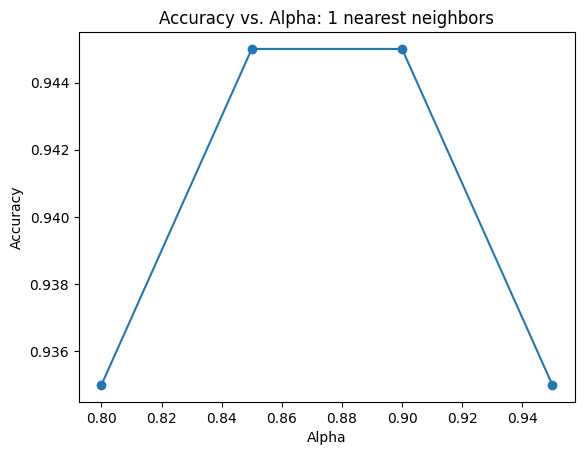

Number of neighbors: 3
Accuracy: 0.91000, Alpha: 0.8
Accuracy: 0.90500, Alpha: 0.85
Accuracy: 0.90500, Alpha: 0.9
Accuracy: 0.89500, Alpha: 0.95


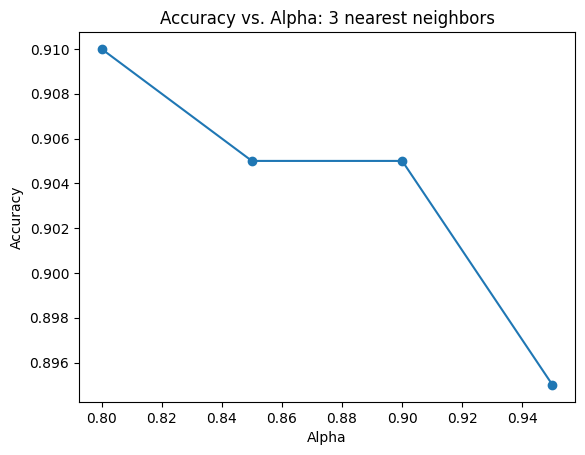

Number of neighbors: 5
Accuracy: 0.87500, Alpha: 0.8
Accuracy: 0.89000, Alpha: 0.85
Accuracy: 0.89500, Alpha: 0.9
Accuracy: 0.88500, Alpha: 0.95


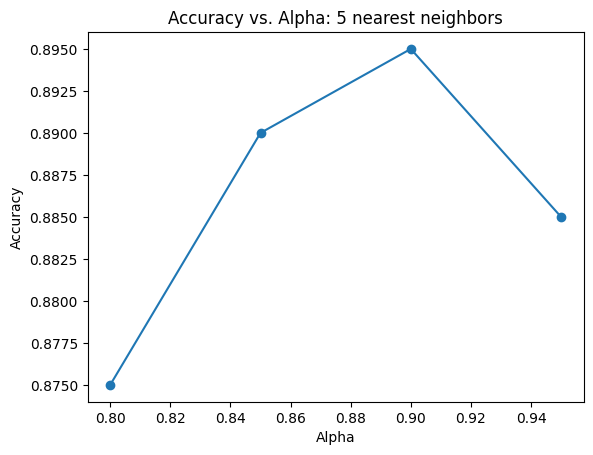

Number of neighbors: 7
Accuracy: 0.86500, Alpha: 0.8
Accuracy: 0.85500, Alpha: 0.85
Accuracy: 0.86000, Alpha: 0.9
Accuracy: 0.86500, Alpha: 0.95


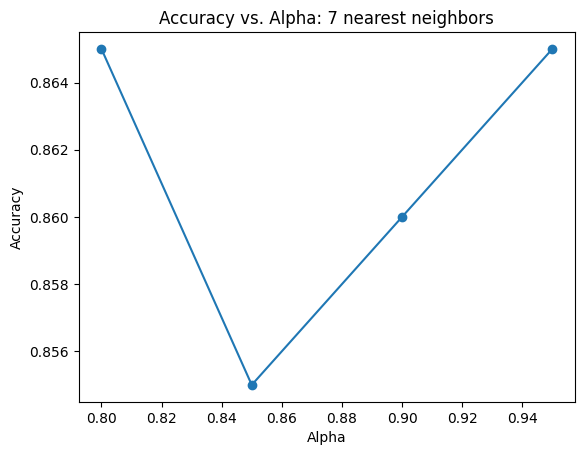

In [ ]:
pca_knn(split_datamatrix_50_50, [1, 3, 5, 7])

**Bonus 1st Part:**
        splitting the data set 70% training and 30% test

Number of neighbors: 1
Accuracy: 0.94697, Alpha: 0.8
Accuracy: 0.94697, Alpha: 0.85
Accuracy: 0.94697, Alpha: 0.9
Accuracy: 0.94697, Alpha: 0.95


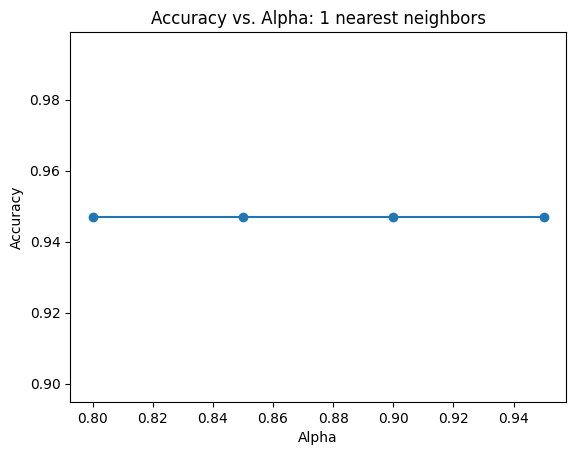

Number of neighbors: 3
Accuracy: 0.92424, Alpha: 0.8
Accuracy: 0.93939, Alpha: 0.85
Accuracy: 0.93182, Alpha: 0.9
Accuracy: 0.91667, Alpha: 0.95


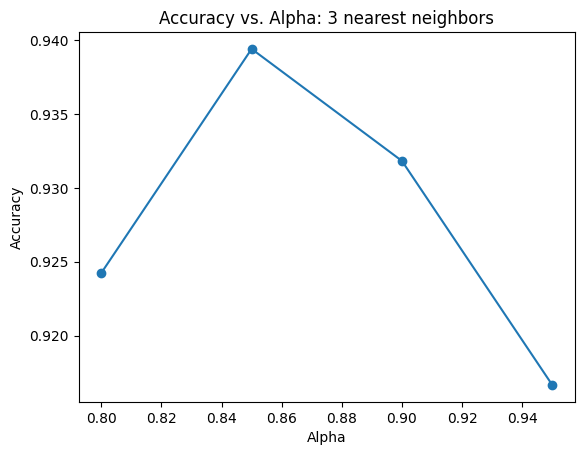

Number of neighbors: 5
Accuracy: 0.90152, Alpha: 0.8
Accuracy: 0.90909, Alpha: 0.85
Accuracy: 0.90152, Alpha: 0.9
Accuracy: 0.88636, Alpha: 0.95


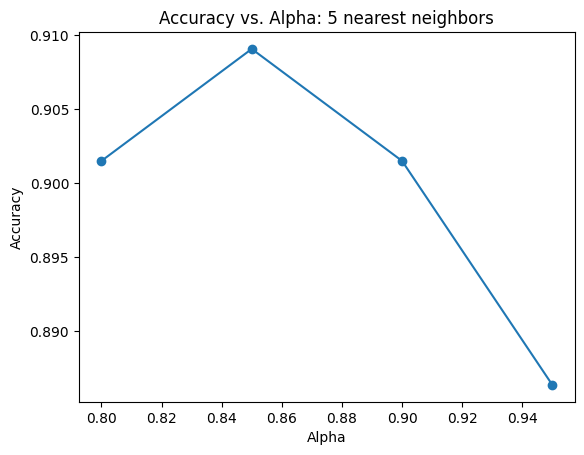

Number of neighbors: 7
Accuracy: 0.89394, Alpha: 0.8
Accuracy: 0.90152, Alpha: 0.85
Accuracy: 0.90152, Alpha: 0.9
Accuracy: 0.87879, Alpha: 0.95


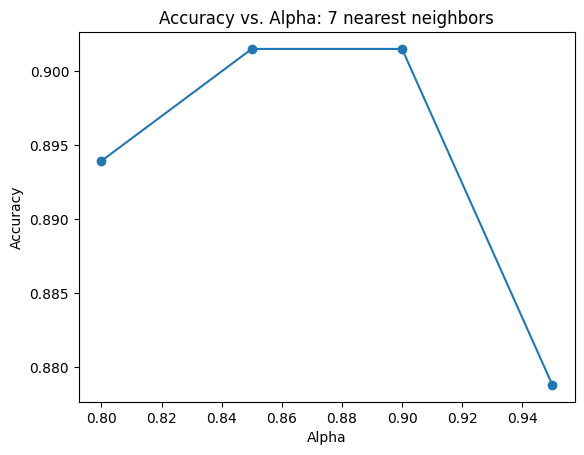

In [ ]:
pca_knn(split_datamatrix_70_30, [1, 3, 5, 7])

**Conclusion:** when alpha passes a certain point, the accuracy decreases. This is due to the noised introduced when taking more components. And by increasing the no. of neighbours, The accuracy decrease, and this is expecetd as the no of pictures per person is 5 and We are looking up to 7 nearest neighbours.

Results from comparsion:
      It becomes more accurate when using 70_30 split (as increasing training set)

# **Part_2: Classification Using LDA**

The following section contains some supplementary methods:

1. **Means Generator():** It calculates the overall mean and class means of a given data matrix

2. **GenerteSB():** This method is called to generate the between-classes scatter matrix

3. **CentralizeData():** This method is used to centralize the Training Data matrix

4. **Compute_Within_Scatter_Class_Martrix():** This method is used to calculate the within_class scatter matrix

5. **Project():** This method is used to project a given sample data into the new dimensions

In [ ]:
def Means_Generator(DataMatrix, labels):
    unique_classes = np.unique(labels)
    class_means = []
    # Iterate over each unique class
    for class_label in unique_classes:
        # Get indices of instances belonging to the current class
        indices = np.where(labels == class_label)[0]
        # Extract instances belonging to the current class
        class_data = DataMatrix[indices, :]  # Include all columns
        # Calculate the mean vector for the current class
        class_mean = np.mean(class_data, axis=0)
        class_means.append(class_mean)
        # Concatenate mean vectors into a new matrix
    return np.mean(DataMatrix, axis=0).reshape(-1,1), np.vstack(class_means)

def GenerateSB(DataMatrix, labels, OverallMean):
    unique_classes = np.unique(labels)
    rows, cols = DataMatrix.shape
    Sb = np.zeros((cols, cols))
    for class_label in unique_classes:
        indices = np.where(labels == class_label)[0]
        classmean = np.mean(DataMatrix[indices, :]).reshape(-1,1)
        Sb+= (rows/40)*np.dot((classmean-OverallMean), (classmean-OverallMean).T)
    return Sb



def CentralizeData(DataMatrix, labels):
    unique_classes = np.unique(labels)
    DataMatrix = DataMatrix.astype(np.float64)
    # Iterate over each unique class
    for class_label in unique_classes:
        # Get indices of instances belonging to the current class
        indices = np.where(labels == class_label)[0]
        # Subtract the mean of the current class from the data
        DataMatrix[indices, :]-= np.mean(DataMatrix[indices, :], axis=0)
    return DataMatrix




def Compute_Within_Scatter_Class_Martrix(CentralizedSet, labels):
      rows, columns = CentralizedSet.shape
      unique_classes = np.unique(labels)
      S = np.zeros((columns, columns))
      for class_label in unique_classes:
          # Get indices of instances belonging to the current class
          indices = np.where(labels == class_label)[0]
          # Subtract the mean of the current class from the data
          Si = CentralizedSet[indices, :]
          S+= np.dot(Si.T, Si)
      return S

def Project(Centralized_Data, Projection_Matrix):
  return np.dot(Centralized_Data, Projection_Matrix)



**The LDA Method is implemented via the following LDA pseudcode:**




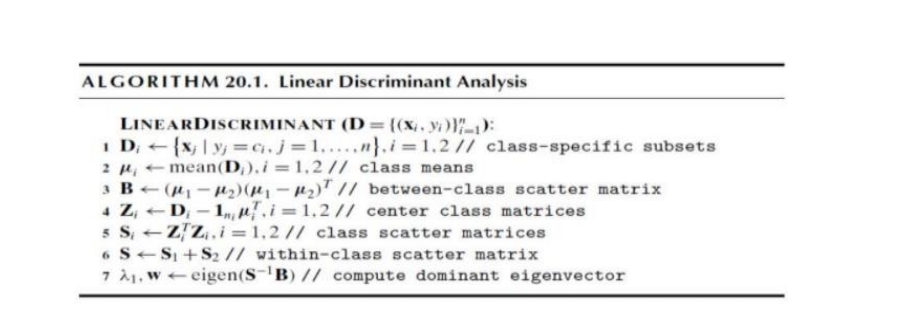



In [ ]:
def LDA(Training_matrix, Training_labels):
  new_matrix = np.hstack((Training_matrix, np.array(Training_labels).reshape(-1, 1)))

  # start_time = time.time()
  OverallMean = np.mean(Training_matrix, axis=0).reshape(-1,1)
  # end_time = time.time()
  # print("Time for Generating the Means", end_time-start_time)
  # print("OverAll Mean", OverallMean, OverallMean.shape)

  # start_time = time.time()
  Sb = GenerateSB(Training_matrix , Training_labels, OverallMean)
  # end_time = time.time()
  # print("Time for generating SB", end_time-start_time)
  # print("Sb", Sb, Sb.shape)

  # start_time = time.time()
  CentralizedSet = CentralizeData(Training_matrix, Training_labels)
  # end_time = time.time()
  # print("Time for Centralizing Data", end_time-start_time)
  # print("Centralized matrix", CentralizedSet, "Size",CentralizedSet.shape, "type", CentralizedSet.dtype )


  # start_time = time.time()
  S = Compute_Within_Scatter_Class_Martrix(CentralizedSet, Training_labels)
  # end_time = time.time()
  # print("Time for Computing S", end_time-start_time)


  # start_time = time.time()
  S_inv = sp.linalg.pinv(S)
  # end_time = time.time()
  # print("Time for calculting the inverse", end_time-start_time)

  start_time = time.time()
  eigenvalues, eigenvectors =np.linalg.eig(np.dot(S_inv, Sb))

  # Getting the sorted indices corresponding to the eigen values
  Sorted_indices = np.argsort(eigenvalues)[::-1]

# Sort eigenvalues and eigenvectors accordingly
  sorted_eigenvalues =  eigenvalues[Sorted_indices]
  sorted_eigenvectors = eigenvectors[:, Sorted_indices]

  sorted_eigenvalues = np.real(sorted_eigenvalues)
  sorted_eigenvectors = np.real(sorted_eigenvectors)

# Extract the first 39 eigenvectors
  ProjectionMatrix = sorted_eigenvectors[:, :39]
# Extract the corresponding eigenvalues
  PM_EigenValues = sorted_eigenvalues[:39]

  # end_time = time.time()
  # print(ProjectionMatrix, "size", ProjectionMatrix.shape)
  # print(PM_EigenValues, "size", PM_EigenValues.shape)
  # print("Time for cumputing the eigenvectors", end_time-start_time)
  # print("Eigen Values", eigenvalues)
  # print("Eigen Vectors", eigenvectors, eigenvectors.shape)
  return ProjectionMatrix

### **Through this method, We project both Training and Testing Matrices into the new dimensions and then classify the Testing samples via KNN classifier at different K values. At last, We evaluate the results through defining the accuracy achieved by the algorithm**

In [ ]:
def LDA_KNN(Splitting_Method,no_of_neighbors = [1]):
    # Extracting the DataMatrix from the sample data
    DataMatrix, Labels = create_datamatrix()

    # Dividing the DataMatrix into Training set and Testing set
    Training_matrix, Test_matrix, Training_labels, Test_labels = Splitting_Method(DataMatrix, Labels)
    # print(Training_matrix, "size", Training_matrix.shape)

    # Generating and Projecting Training Set into the new dimensions
    Projection_Matrix = LDA(Training_matrix, Training_labels)
    Projected_Training_Data = Project(Training_matrix, Projection_Matrix)
    # print("Projected Training", Projected_Training_Data, "size", Projected_Training_Data.shape)

    # Projecting the Testing set into the new dimensions
    Projected_Testing_Data = Project(Test_matrix, Projection_Matrix)
    # print("Projected Testing", Projected_Testing_Data, "size", Projected_Testing_Data.shape)
    X = []
    Y = []

    # Classifying the Testing set and evaluating the accuracy of the results
    for n in no_of_neighbors:
        print(f"Number of neighbors: {n}")
        KNN = KNeighborsClassifier(n_neighbors=n, weights='distance')
        KNN.fit(Projected_Training_Data, Training_labels)
        y_pred = KNN.predict(Projected_Testing_Data)
        accuracy = accuracy_score(y_pred, Test_labels)
        print(f"Number of neighbors: {n}", "Accuracy", accuracy)
        X.append(n)
        Y.append(accuracy)


    print(X, Y)

    # Plotting
    plt.plot(X, Y, marker='o')
    plt.xlabel('N')
    plt.ylabel('Accuracy')
    plt.title("Accuracy vs N_neighbours")
    plt.show()
    return Projection_Matrix

[[ 60  60  62 ...  32  34  34]
 [ 63  53  35 ...  41  10  24]
 [ 10  43  50 ... 156 155 158]
 ...
 [123 121 126 ...  40  35  42]
 [125 119 124 ...  36  39  40]
 [125 124 124 ...  36  35  34]] size (200, 10304)
Time for Generating the Means 0.004004001617431641
OverAll Mean [[82.04 ]
 [84.87 ]
 [85.23 ]
 ...
 [77.23 ]
 [74.35 ]
 [73.355]] (10304, 1)
Time for generating SB 36.06239056587219
Sb [[221095.71695306 203845.45250236 201651.07257223 ... 250415.07101944
  267970.11046043 274035.1327673 ]
 [203845.45250236 188196.96805166 186206.34812153 ... 230442.34656874
  246367.30600973 251869.1583166 ]
 [201651.07257223 186206.34812153 184241.64819141 ... 227901.64663861
  243619.24607961 249049.45838648]
 ...
 [250415.07101944 230442.34656874 227901.64663861 ... 284361.64508582
  304687.24452681 311709.45683368]
 [267970.11046043 246367.30600973 243619.24607961 ... 304687.24452681
  326671.72396781 334267.05627468]
 [274035.1327673  251869.1583166  249049.45838648 ... 311709.45683368
  334

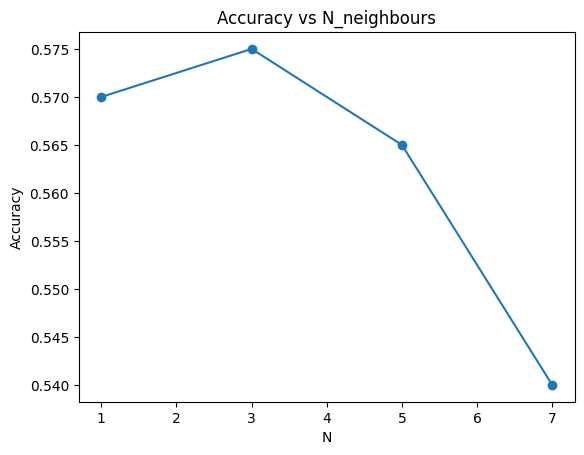

In [ ]:
PM = LDA_KNN(split_datamatrix_50_50, [1, 3, 5, 7])

Number of neighbors: 1
Number of neighbors: 1 Accuracy 0.6515151515151515
Number of neighbors: 3
Number of neighbors: 3 Accuracy 0.6439393939393939
Number of neighbors: 5
Number of neighbors: 5 Accuracy 0.6136363636363636
Number of neighbors: 7
Number of neighbors: 7 Accuracy 0.5909090909090909
[1, 3, 5, 7] [0.6515151515151515, 0.6439393939393939, 0.6136363636363636, 0.5909090909090909]


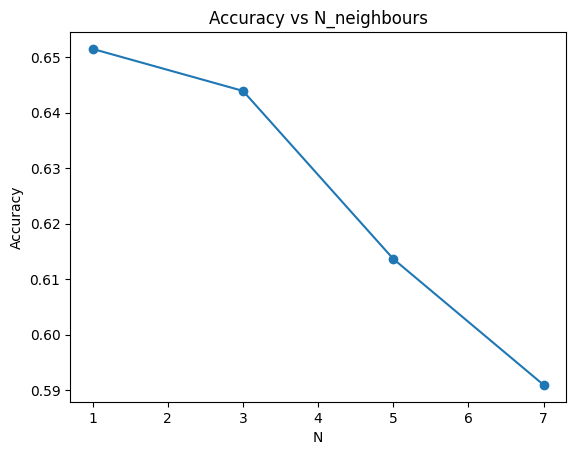

In [ ]:
PM = LDA_KNN(split_datamatrix_70_30, [1, 3, 5, 7])

**Conclusion:** Unlike Expectations, The performance of the LDA was not good as The PCA compared to the results. The accuracy when applying LDA was less than that of PCA regarding this Dataset. However, The accuracy of LDA increases compared to itself when our sample data splitted with ratio of 7:3 and this is logically correct as the training data increased per each class which introduced higher accuracy.



# **Adding Non Faces**

In [ ]:
def pca_knn_non_faces(fixing_test_no, split_50=True, no_of_non_faces=[300]):
    x = []
    y = []
    for n in no_of_non_faces:
        knn = KNeighborsClassifier(n_neighbors=1, weights='distance')
        training_vector, test_vector, training_label, test_label = \
            create_faces_non_faces_datamatrix(n, split_50, fixing_test_no=fixing_test_no)
        new_projected_training_data, projection_matrix, means = PCA(training_vector, 0.8)
        new_projected_test_data = project_data_with_old_projection_matrix(test_vector, projection_matrix, means)
        knn.fit(new_projected_training_data, training_label)
        y_pred = knn.predict(new_projected_test_data)
        accuracy = accuracy_score(y_pred, test_label)
        x.append(n-200)
        y.append(accuracy)
        print(f"Accuracy: {accuracy:.5f}, Alpha: {0.8}")

    # Plotting
    plt.plot(x, y, marker='o')
    plt.xlabel('no of non faces in training set')
    plt.ylabel('Accuracy')
    plt.title(f"Accuracy vs. no_of_non_faces")
    plt.show()

[link text](https://)7) ii)
The number of dominant eigenvectors to be used will equal to 1, As, for this problem we are trying to classify the sampled data through only 2 different classes, and hence only one Eigen vector will be sufficient for the solution

7)iii)Plot the accuracy vs the number of non-faces images while fixing
the number of face images.

Accuracy: 0.96857, Alpha: 0.8
Accuracy: 0.96000, Alpha: 0.8
Accuracy: 0.97111, Alpha: 0.8
Accuracy: 0.97800, Alpha: 0.8
Accuracy: 0.97818, Alpha: 0.8
Accuracy: 0.98167, Alpha: 0.8
Accuracy: 0.98000, Alpha: 0.8
Accuracy: 0.97571, Alpha: 0.8


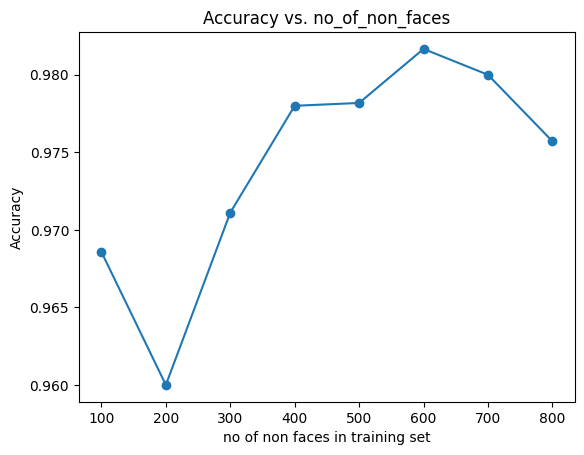

In [ ]:
pca_knn_non_faces(fixing_test_no=False, split_50=True, no_of_non_faces=[300, 400, 500, 600, 700, 800, 900, 1000])

Accuracy: 0.97835, Alpha: 0.8
Accuracy: 0.97348, Alpha: 0.8
Accuracy: 0.97643, Alpha: 0.8
Accuracy: 0.97576, Alpha: 0.8
Accuracy: 0.98072, Alpha: 0.8
Accuracy: 0.98237, Alpha: 0.8
Accuracy: 0.98376, Alpha: 0.8
Accuracy: 0.98710, Alpha: 0.8


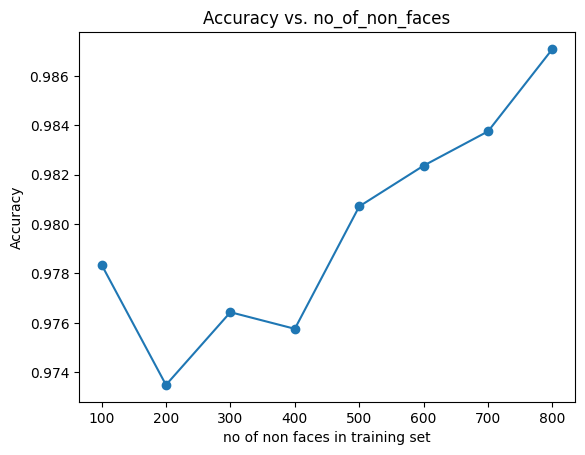

In [ ]:
pca_knn_non_faces(fixing_test_no=False, split_50=False, no_of_non_faces=[300, 400, 500, 600, 700, 800, 900, 1000])

7)iv)Criticize the accuracy measure for large numbers of non-faces
images in the training data.

Accuracy: 0.93500, Alpha: 0.8
Accuracy: 0.96000, Alpha: 0.8
Accuracy: 0.97000, Alpha: 0.8
Accuracy: 0.98500, Alpha: 0.8
Accuracy: 0.98750, Alpha: 0.8
Accuracy: 0.99250, Alpha: 0.8
Accuracy: 0.99500, Alpha: 0.8
Accuracy: 0.99500, Alpha: 0.8


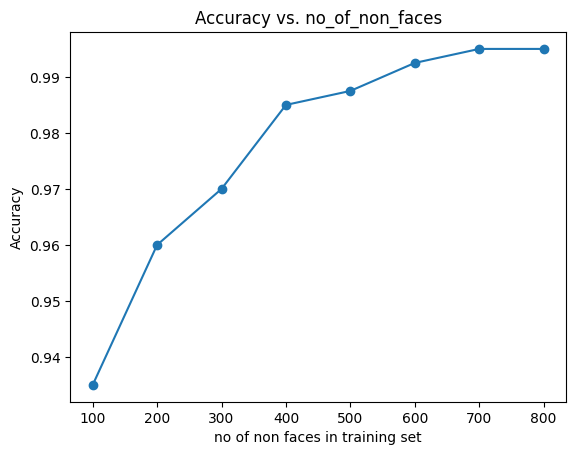

In [ ]:
pca_knn_non_faces(fixing_test_no=True, split_50=True, no_of_non_faces=[300, 400, 500, 600, 700, 800, 900, 1000])

Accuracy: 0.91867, Alpha: 0.8
Accuracy: 0.95181, Alpha: 0.8
Accuracy: 0.96386, Alpha: 0.8
Accuracy: 0.98795, Alpha: 0.8
Accuracy: 0.98795, Alpha: 0.8
Accuracy: 0.99096, Alpha: 0.8
Accuracy: 0.99096, Alpha: 0.8
Accuracy: 0.99699, Alpha: 0.8


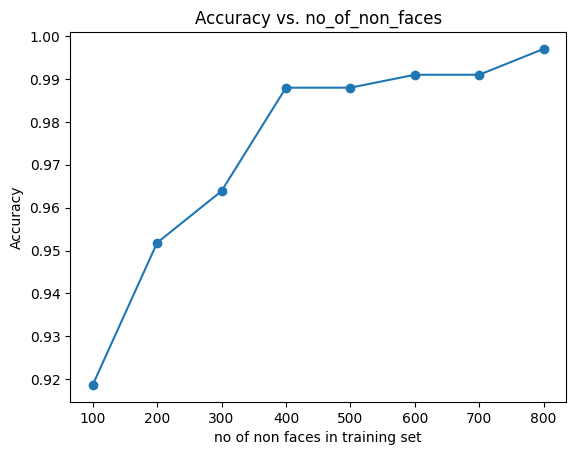

In [ ]:
pca_knn_non_faces(fixing_test_no=True, split_50=False, no_of_non_faces=[300, 400, 500, 600, 700, 800, 900, 1000])

# **LDA**

In [ ]:
def LDA_knn_non_faces(fixing_test_no, split_50=True, no_of_non_faces=[300]):
    x = []
    y = []
    for n in no_of_non_faces:
        knn = KNeighborsClassifier(n_neighbors=1, weights='distance')
        training_vector, test_vector, training_label, test_label = \
            create_faces_non_faces_datamatrix(n, split_50, fixing_test_no=fixing_test_no)
        projection_matrix = LDA(training_vector, training_label)
        means = np.mean(training_vector, axis=0)
        new_projected_training_data = project_data_with_old_projection_matrix(training_vector, projection_matrix, means)
        new_projected_test_data = project_data_with_old_projection_matrix(test_vector, projection_matrix, means)
        knn.fit(new_projected_training_data, training_label)
        y_pred = knn.predict(new_projected_test_data)
        accuracy = accuracy_score(y_pred, test_label)
        x.append(n-200)
        y.append(accuracy)
        print(f"Accuracy: {accuracy:.5f}")

    # Plotting
    plt.plot(x, y, marker='o')
    plt.xlabel('no of non faces in training set')
    plt.ylabel('Accuracy')
    plt.title(f"Accuracy vs. no_of_non_faces")
    plt.show()

Accuracy: 0.94286
Accuracy: 0.92750
Accuracy: 0.92444
Accuracy: 0.95200


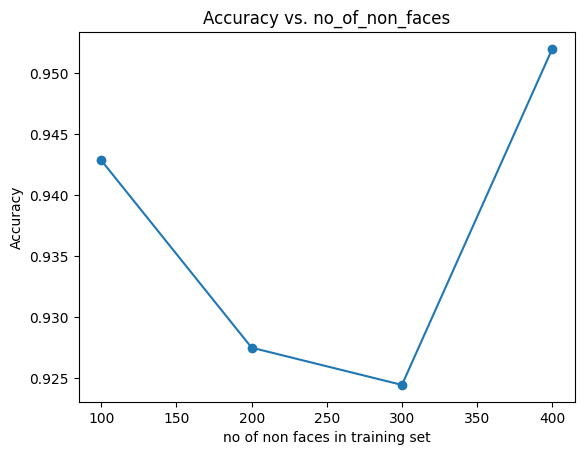

In [ ]:
LDA_knn_non_faces(fixing_test_no=False, split_50=True, no_of_non_faces=[300, 400, 500, 600])

Accuracy: 0.91566
Accuracy: 0.92470
Accuracy: 0.93976
Accuracy: 0.92470


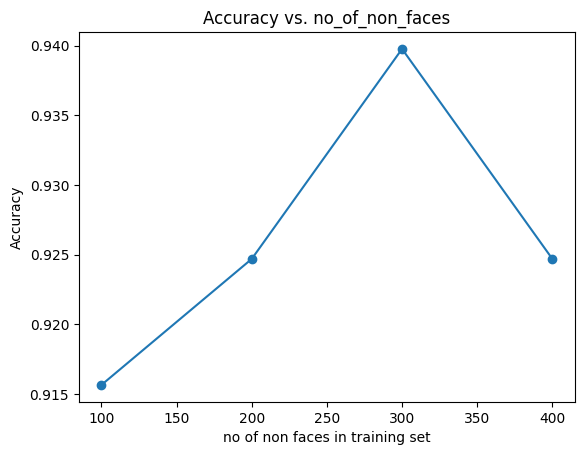

In [ ]:
LDA_knn_non_faces(fixing_test_no=True, split_50=False, no_of_non_faces=[300, 400, 500, 600])

# **Bonus Part 2**

# ***Randomized pca***

Comparing normal PCA and Randomized PCA, the randomized PCA is faster and it doesn't get the exact eigenVectors through eigenvectors decomposition, but it uses random projections instead to lower the dimension space.

Accuracy:  0.925
Accuracy:  0.945
Accuracy:  0.945
Accuracy:  0.935


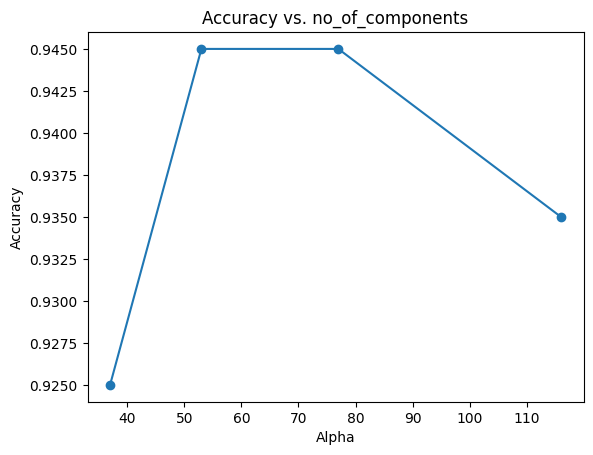

In [ ]:
# like alpha = 0.8,0.85,0.9,0.95 when no of neighbours = 1
n_components = [37, 53, 77, 116]
alpha = [0.8, 0.85, 0.9, 0.95]
x = []
y = []
for n in n_components:
    pca = skPCA(n_components=n, svd_solver='randomized')
    X_train, X_labels, = create_datamatrix()
    knn = KNeighborsClassifier(n_neighbors=1, weights='distance')
    training_vector, test_vector, training_label, test_label = split_datamatrix_50_50(X_train, X_labels)
    means = np.mean(training_vector, axis=0)
    new_projected_training_data = pca.fit_transform(training_vector)
    new_projected_test_data = pca.transform(test_vector)
    knn.fit(new_projected_training_data, training_label)
    y_pred = knn.predict(new_projected_test_data)
    accuracy = accuracy_score(y_pred, test_label)
    print("Accuracy: ", accuracy)
    y.append(accuracy)

plt.plot(n_components, y, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title(f"Accuracy vs. no_of_components")
plt.show()


## Regularized LDA

LSQR (Least square quadratic curve algorithm) finds the best curve that fits the given observations which have the minimum sum of square residuals

In [ ]:
lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage = 0.5)
X_train, X_labels, = create_datamatrix()
training_vector, test_vector, training_label, test_label = split_datamatrix_50_50(X_train, X_labels)
lda.fit(training_vector, training_label)
y_pred = lda.predict(test_vector)
accuracy = accuracy_score(y_pred, test_label)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9750
